Time Series Forecasting with XGBoost

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
color_pal = sns.color_palette()

In [125]:
df = pd.read_csv('./data/ACC-Rain-AlbertParkAccRainfall_20220818-20230818-onemins.csv')
df.head()


,Timestamp,UTC Offset,Multiple Gauge Rainfall Recency Alarm (on/off),Quality,Rainfall (mm),Quality.1,Rainfall (Accumulated) (mm),Quality.2
0,2022-08-18 14:21:00,12,NaN,No data available,NaN,No data available,0.0,Automated Process or Synthetic
1,2022-08-18 14:22:00,12,NaN,No data available,NaN,No data available,0.0,Automated Process or Synthetic
2,2022-08-18 14:23:00,12,NaN,No data available,NaN,No data available,0.0,Automated Process or Synthetic
3,2022-08-18 14:24:00,12,NaN,No data available,NaN,No data available,0.0,Automated Process or Synthetic
4,2022-08-18 14:25:00,12,NaN,No data available,NaN,No data available,0.0,Automated Process or Synthetic


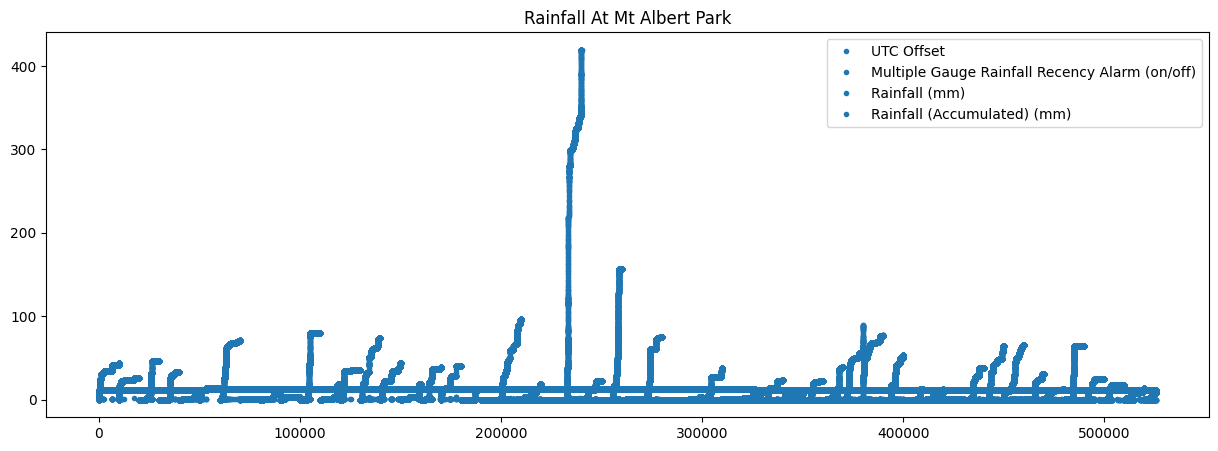

In [126]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Rainfall At Mt Albert Park')
plt.show()

<Axes: title={'center': 'Rainfall at Mt Albert 2022 August to 2023 Auguest'}, xlabel='Timestamp'>

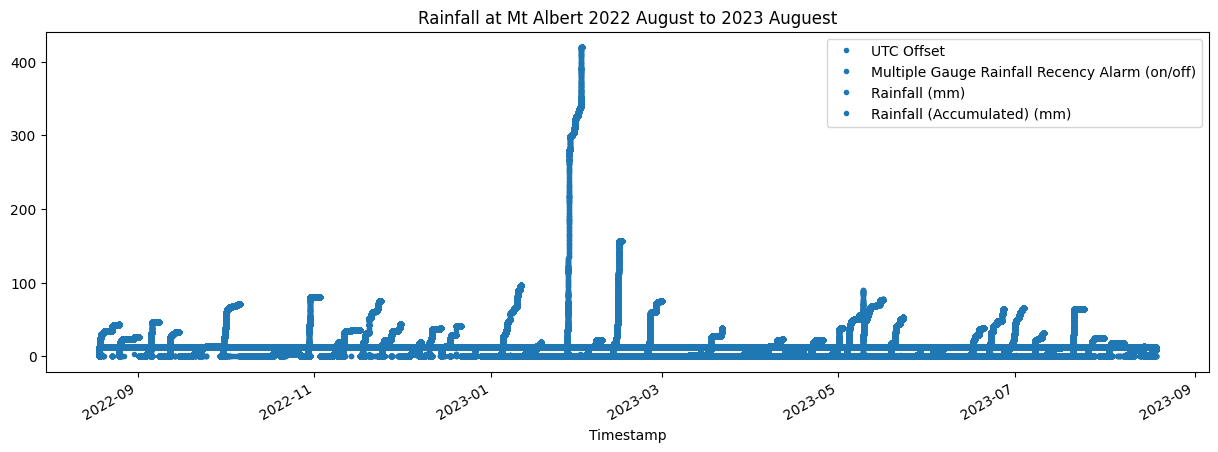

In [127]:
df = df.set_index('Timestamp')
df.index = pd.to_datetime(df.index)
df.plot(style='.', figsize=(15,5), color = color_pal[0], title='Rainfall at Mt Albert 2022 August to 2023 Auguest')